In [1]:
import sys
sys.path.append("/data/vision/phillipi/perception/hw4dl_final_project/hw4dl/loaders")
sys.path.append("/data/vision/phillipi/perception/hw4dl/datasets")
from loaders.map2loc_loader import Map2Loc
from models.shared_cnn import VariableCNNBackbone
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.distributions.normal import Normal
from torchvision import transforms
import pdb
import matplotlib.pyplot as plt

/data/scratch/shobhita/miniconda3/envs/lpips2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [86]:
all_results = {}

In [2]:
task = "pixel"
train_dataset = Map2Loc(root_dir=f'datasets/map2loc_{task}', csv_file='description.csv')
test_dataset = Map2Loc(root_dir=f'datasets/map2loc_{task}_test', csv_file='description.csv')
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [int(len(train_dataset) * 0.8), int(len(train_dataset) * 0.2)])

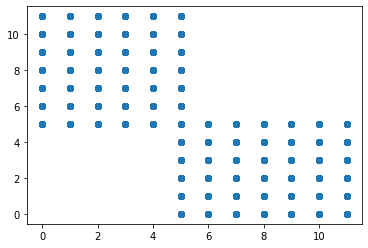

In [184]:
import os
import pandas as pd
import numpy as np
ROOT_DIR = "/data/vision/phillipi/perception/hw4dl_final_project"
dir = os.path.join(ROOT_DIR, 'hw4dl/datasets/map2loc_patch/')
df = pd.read_csv(os.path.join(dir, 'description.csv'))
x = df['X'].to_numpy()
y = df['Y'].to_numpy()
toplot_x = []
toplot_y = []
patch_size = 2
for i, j in zip(x, y):
    x_grid, y_grid = np.meshgrid(list(range(i, i + patch_size + 1)), list(range(j, j + patch_size + 1)))
    toplot_x += list(x_grid.flatten())
    toplot_y += list(y_grid.flatten())
plt.figure()
plt.plot(toplot_x, toplot_y, 'o')
plt.show()

In [336]:
toplot_y

[0,
 0,
 0,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 4,
 4,
 4,
 5,
 5,
 5,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 9,
 9,
 9,
 1,
 1,
 1,
 2,
 2,
 2,
 3,
 3,
 3,
 2,
 2,
 2,
 3,
 3,
 3,
 4,
 4,
 4,
 5,
 5,
 5,
 6,
 6,
 6,
 7,
 7,
 7,
 6,
 6,
 6,
 7,
 7,
 7,
 8,
 8,
 8,
 0,
 0,
 0,
 1,
 1,
 1,
 2,
 2,
 2,
 7,
 7,
 7,
 8,
 8,
 8,
 9,
 9,
 9,
 8,
 8,
 8,
 9,
 9,
 9,
 10,
 10,
 10,
 1,
 1,
 1,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 5,
 5,
 5,
 1,
 1,
 1,
 2,
 2,
 2,
 3,
 3,
 3,
 7,
 7,
 7,
 8,
 8,
 8,
 9,
 9,
 9,
 0,
 0,
 0,
 1,
 1,
 1,
 2,
 2,
 2,
 0,
 0,
 0,
 1,
 1,
 1,
 2,
 2,
 2,
 0,
 0,
 0,
 1,
 1,
 1,
 2,
 2,
 2,
 0,
 0,
 0,
 1,
 1,
 1,
 2,
 2,
 2,
 6,
 6,
 6,
 7,
 7,
 7,
 8,
 8,
 8,
 5,
 5,
 5,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 9,
 9,
 9,
 3,
 3,
 3,
 4,
 4,
 4,
 5,
 5,
 5,
 3,
 3,
 3,
 4,
 4,
 4,
 5,
 5,
 5,
 3,
 3,
 3,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 7,
 7,
 7,
 2,
 2,
 2,
 3,
 3,
 3,
 4,
 4,
 4,
 3,
 3,
 3,
 4,
 4,
 4,
 

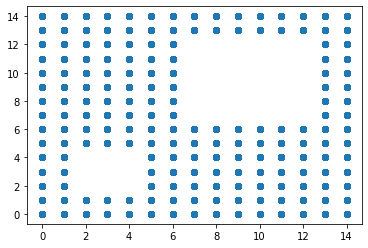

In [3]:
import os
import pandas as pd
import numpy as np
ROOT_DIR = "/data/vision/phillipi/perception/hw4dl_final_project"
dir = os.path.join(ROOT_DIR, 'hw4dl/datasets/map2loc_pixel/')
df = pd.read_csv(os.path.join(dir, 'description.csv'))
x = df['X'].to_numpy()
y = df['Y'].to_numpy()
plt.figure()
plt.plot(x, y, 'o')
plt.show()

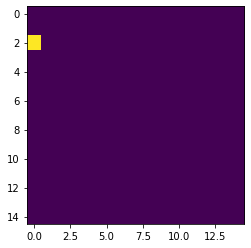

In [4]:
plt.imshow(transforms.ToPILImage()(train_dataset[0][0]))

In [94]:
device="cuda"
lr = 1e-4

In [109]:
if task == "pixel":
    layer_shapes = (1, 16, -1, 32, -1, 64, 128, 256, 'fc512', 'fc2')
else:
    layer_shapes = (1, 16, -1, 32, -1, 64, 128, 256, 'fc512', 'fc18')
split_idx = 7
num_heads = 3
n_epochs = 5
model = VariableCNNBackbone(layer_shapes, split_idx, num_heads, input_size=(15,15), task=task)

def make_sigma_positive(sigma):
  return torch.log(1 + torch.exp(sigma)) + 1e-6

def nll_loss(outputs, labels):
  """
  Negative log likelihood loss
  Outputs: B x 2
  Labels: B x 1
  """
  mu, sigma = torch.split(outputs, 1, dim=1)
  sigma = make_sigma_positive(sigma)
  cond_dist_x = Normal(loc=mu, scale=sigma)
  loss = -cond_dist_x.log_prob(labels)

  return loss.mean()

In [110]:
def eval(model, model_type, scramble_batches, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    for inputs, labels in tqdm(loader):
        batch_loss = 0.0
        inputs, labels = inputs.type(torch.float32).to(device), labels.type(torch.float32).to(device)
        outputs = model(inputs)
        if model_type == "shared":
            for head_i, output in enumerate(outputs):
                if scramble_batches:
                  batch_loss += criterion(output, labels[:,:,head_i])
                else:
                  batch_loss += criterion(output, labels)
        else:
            batch_loss = criterion(outputs, labels)
        total_loss += batch_loss.item()
    return total_loss / len(loader)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

model.to(device)

criterion = nll_loss
optimizer = optim.Adam(model.parameters(), lr=lr)

val_loss = eval(model, "shared", False, val_loader, criterion, device)
print("Initial val loss, ", val_loss)

# Training loop
for i in range(n_epochs):
    model.train()
    total_train_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        inputs = inputs.type(torch.float32)
        labels = labels.type(torch.float32)
        batch_loss = 0.0
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        for head_i, output in enumerate(outputs):
            batch_loss += criterion(output, labels)
        batch_loss.backward()
        optimizer.step()
        total_train_loss += batch_loss.item()

    train_loss = total_train_loss / len(train_loader)
    val_loss = eval(model, "shared", False, val_loader, criterion, device)
    print(f"Epoch {i}, train loss: {train_loss}, val loss: {val_loss}")

test_loss = eval(model, "shared", False, test_loader, criterion, device)
print(f"Test loss: {test_loss}")

# print(f"Saving model and config")
# save_model(model, dict(test_loss=test_loss), args)

print("Done :)")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:10<00:00, 12.35it/s]


Initial val loss,  6.916227909088135


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:10<00:00, 12.44it/s]


Epoch 0, train loss: 4.482385175228119, val loss: 4.337122785568237


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:10<00:00, 12.09it/s]


Epoch 1, train loss: 4.37879837179184, val loss: 4.335493774414062


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 11.15it/s]


Epoch 2, train loss: 4.37698360157013, val loss: 4.3347251605987545


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:10<00:00, 12.13it/s]


Epoch 3, train loss: 4.375940751552582, val loss: 4.3343035583496095


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:10<00:00, 12.00it/s]


Epoch 4, train loss: 4.375279059886933, val loss: 4.334030071258545


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:25<00:00, 12.12it/s]

Test loss: 4.4790347399422155
Done :)


In [111]:
def get_mask_from_gaps(gaps, shape):
  mask = np.ones(shape)
  for gap in gaps:
    xx, yy = np.meshgrid(list(range(gap[0], gap[1] + 1)), list(range(gap[2], gap[3] + 1)))
    mask[xx, yy] = 0
  return mask.flatten()
def score_cnn_performance(model,
                             test_loader,
                             epi_threshold:float=0.1,
                             device:str="cpu",
                             )->plt.Axes:
  model.eval()
  testx, testy = np.meshgrid(np.arange(15), np.arange(15))
  coords = []
  all_inputs = []
  for x, y in zip(testx.ravel(), testy.ravel()):
    inputs = np.zeros((15, 15))
    inputs[x, y] = 1
    all_inputs.append(torch.tensor(inputs))
    coords.append((x, y))
  coords = np.array(coords)
  inputs = torch.stack(all_inputs).unsqueeze(1).type(torch.float32).to(device)
  outputs = model(inputs)
  values = torch.stack(outputs).squeeze(-1)
  means = values[:, :, 0].mean(dim=0)
  sigma = torch.sqrt(
    torch.mean(make_sigma_positive(values[:, :, 1]) + torch.square(values[:, :, 0]), dim=0) - torch.square(means))
  epistemic_sigma = torch.std(values[:, :, 0], dim=0)
  epistemic_sigma = epistemic_sigma.detach().cpu().numpy()
  classified_data_region = epistemic_sigma < epi_threshold


  mask = get_mask_from_gaps(test_loader.gaps, test_loader.shape).astype(bool)

  x_input = (2 * testx.ravel()) / test_loader.shape[0] - 1
  y_input = (2 * testy.ravel()) / test_loader.shape[0] - 1
  gt_mean = test_loader.polyf(x_input, y_input)
  gt_var = test_loader.varf(x_input, y_input)

  samples_correct = np.sum(
    np.logical_and(classified_data_region, mask)
  ) + np.sum(np.logical_and(np.logical_not(classified_data_region), np.logical_not(mask)))
  total_samples = len(testx) * len(testy)

  means_arr = means.detach().cpu().numpy()
  sigma_arr = sigma.detach().cpu().numpy()
  mean_mse = np.mean(np.square(means_arr[mask] - gt_mean[mask]))
  mean_sigma = np.mean(np.square(np.square(sigma_arr[mask]) - gt_var[mask]))
  print(f"Mean MSE: {mean_mse}")
  print(f"Mean Sigma: {mean_sigma}")
  print(f"Percentage of samples classified correctly: {samples_correct / total_samples}")
  return mean_mse, mean_sigma, samples_correct/total_samples

mean_mse, mean_sigma, classified = score_cnn_performance(model, test_dataset, epi_threshold=0.001,device=device)
all_results[split_idx] = {
    'mean_mse': mean_mse,
    'mean_sigma': mean_sigma,
    'correct': classified
}

Mean MSE: 0.17630185567380602
Mean Sigma: 0.18057789777345482
Percentage of samples classified correctly: 0.2


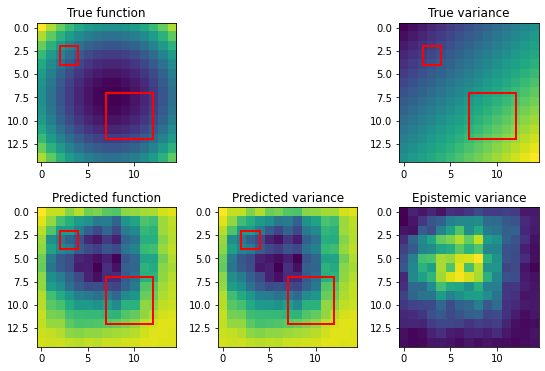

In [112]:
from matplotlib.patches import Rectangle

testx, testy = np.meshgrid(np.arange(15), np.arange(15))
x_input = (2 * testx.ravel()) / test_dataset.shape[0] - 1
y_input = (2 * testy.ravel()) / test_dataset.shape[0] - 1
gt_mean = test_dataset.polyf(x_input, y_input)
gt_var = test_dataset.varf(x_input, y_input)

# fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(5,5))
# fig.tight_layout()
plt.figure(figsize=(9,6))
ax1 = plt.subplot(231)
ax2 = plt.subplot(233)
ax3 = plt.subplot(234)
ax4 = plt.subplot(235)
ax5 = plt.subplot(236)
# plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.3)

axes = [ax1, ax2, ax3, ax4, ax5]
# axes = axes.flatten()
axes[0].imshow(gt_mean.reshape((15,15)))
axes[0].set_title("True function")
axes[1].imshow(gt_var.reshape((15,15)))
axes[1].set_title("True variance")

all_inputs = []
for x, y in zip(testx.ravel(), testy.ravel()):
    inputs = np.zeros((15, 15))
    inputs[x, y] = 1
    all_inputs.append(torch.tensor(inputs))
inputs = torch.stack(all_inputs).unsqueeze(1).type(torch.float32).to(device)
outputs = model(inputs)
values = torch.stack(outputs).squeeze(-1)
means = values[:, :, 0].mean(dim=0)
means_arr = means.detach().cpu().numpy()
axes[2].imshow(means_arr.reshape((15,15)))
axes[2].set_title("Predicted function")

sigma = torch.sqrt(
torch.mean(make_sigma_positive(values[:, :, 1]) + torch.square(values[:, :, 0]), dim=0) - torch.square(means))
sigma = sigma.detach().cpu().numpy()
epistemic_sigma = torch.std(values[:, :, 1], dim=0)
epistemic_sigma = epistemic_sigma.detach().cpu().numpy()

axes[3].imshow(np.square(sigma).reshape((15,15)))
axes[3].set_title("Predicted variance")

axes[4].imshow(np.square(epistemic_sigma).reshape((15,15)))
axes[4].set_title("Epistemic variance")
for gap in test_dataset.gaps:
    for i in range(4):
        width = gap[1] - gap[0]
        height = gap[3] - gap[2]
        x1, y1 = gap[0], gap[2]
        rect = Rectangle((x1, y1), width, height, linewidth=2, edgecolor='red', facecolor='none')
        axes[i].add_patch(rect)

In [114]:
pd.DataFrame(all_results)

,4,1,7
mean_mse,0.177693,0.175486,0.176302
mean_sigma,0.181809,0.180653,0.180578
correct,0.337778,0.213333,0.200000


In [85]:
plt.savefig

<function matplotlib.pyplot.savefig(*args, **kwargs)>

In [42]:
test_loader.gaps

[(2, 4, 2, 4), (7, 12, 7, 12)]

In [ ]:
# def plot_network_performance(model:nn.Module,
#                              toy_loader:PolyData,
#                              device:str="cpu",
#                              )->plt.Axes:
    
fig, ax = plt.subplots()
ax.set_xlim(toy_loader.lower, toy_loader.upper)
samples = np.linspace(toy_loader.lower, toy_loader.upper, 1000)
var = toy_loader.varf(samples)
ax.scatter(toy_loader.x, toy_loader.y, marker='.', alpha=0.1, label="Training Data")
print(toy_loader.x)
ax.plot(samples, toy_loader.polyf(samples), label="True Function")
ax.fill_between(samples, toy_loader.polyf(samples) - var, toy_loader.polyf(samples) + var, alpha=0.5, label="True Variance")

torch_input = torch.unsqueeze(torch.tensor(samples, dtype=torch.float32), 1).to(device)
model.to(device)
model.eval()
model.scramble_batches = False
outputs = model(torch_input)
values = torch.stack(outputs).squeeze(-1)
for i in range(values.shape[0]):
ax.plot(samples, values[i,:,0].detach().cpu().numpy(), alpha=0.5, label="_Network Prediction")
means = values[:,:,0].mean(dim=0)
sigma = torch.sqrt(torch.mean(make_sigma_positive(values[:,:,1]) + torch.square(values[:,:,0]), dim=0) - torch.square(means))
epistemic_sigma = torch.std(values[:,:,0], dim=0)
means = means.detach().cpu().numpy()
sigma = sigma.detach().cpu().numpy()
epistemic_sigma = epistemic_sigma.detach().cpu().numpy()
print(epistemic_sigma)
ax.plot(samples, means, label="Mean Prediction")
ax.fill_between(samples, means - np.square(sigma), means + np.square(sigma), alpha=0.5, label="Predicted Variance")
ax.fill_between(samples, means - np.square(epistemic_sigma), means + np.square(epistemic_sigma), alpha=0.5, label="Epistemic Variance")
ax.legend()

In [194]:
import matplotlib.pyplot as plt 
import torch.nn as nn
# from hw4dl.loaders.toy_loader import PolyData
import numpy as np 
# from hw4dl.tools.manage_models import load_model, get_most_recent_model
# from hw4dl.train import make_polyf, make_sigma_positive
from torch.utils.data import DataLoader
# from hw4dl.loaders.toy_loader import construct_intervals
import torch

In [195]:
def get_mask_from_gaps(gaps, shape):
    mask = np.ones(shape)
    for gap in gaps:
        xx, yy = np.meshgrid(list(range(gap[0], gap[1] + 1)), list(range(gap[2], gap[3] + 1)))
        mask[xx, yy] = 0
    return mask.flatten()
model.eval()
testx, testy = np.meshgrid(np.arange(15), np.arange(15))
coords = []
all_inputs = []
for x, y in zip(testx.ravel(), testy.ravel()):
    inputs = np.zeros((15, 15))
    inputs[x, y] = 1
    all_inputs.append(torch.tensor(inputs))
    coords.append((x, y))
coords = np.array(coords)
inputs = torch.stack(all_inputs).unsqueeze(1).type(torch.float32).to(device)
outputs = model(inputs)
values = torch.stack(outputs).squeeze(-1)
means = values[:,:,0].mean(dim=0)
sigma = torch.sqrt(torch.mean(make_sigma_positive(values[:,:,1]) + torch.square(values[:,:,0]), dim=0) - torch.square(means))
epistemic_sigma = torch.std(values[:,:,0], dim=0)
epistemic_sigma = epistemic_sigma.detach().cpu().numpy()
classified_data_region = epistemic_sigma < 0.005

gaps = [(2, 4, 2, 4), (7, 10, 7, 10)]
shape = (15, 15)
mask = get_mask_from_gaps(gaps, shape).astype(bool)

x_input = (2 * testx.ravel()) / shape[0] - 1
y_input = (2 * testy.ravel()) / shape[0] - 1
gt_mean = polyf(x_input, y_input)
gt_var = varf(x_input, y_input)

samples_correct = np.sum(
np.logical_and(classified_data_region, mask)
) + np.sum(np.logical_and(np.logical_not(classified_data_region), np.logical_not(mask)))
total_samples = len(testx) * len(testy)

means_arr = means.detach().cpu().numpy()
sigma_arr = sigma.detach().cpu().numpy()
mean_mse = np.mean(np.square(means_arr[mask] - gt_mean[mask]))
mean_sigma = np.mean(np.square(np.square(sigma_arr[mask]) - gt_var[mask]))
print(f"Mean MSE: {mean_mse}")
print(f"Mean Sigma: {mean_sigma}")
print(f"Percentage of samples classified correctly: {samples_correct/total_samples}")

ValueError: operands could not be broadcast together with shapes (225,3,3) (225,) 

[array([[ 0,  3,  6,  9, 12],
        [ 0,  3,  6,  9, 12],
        [ 0,  3,  6,  9, 12],
        [ 0,  3,  6,  9, 12],
        [ 0,  3,  6,  9, 12]]),
 array([[ 0,  0,  0,  0,  0],
        [ 3,  3,  3,  3,  3],
        [ 6,  6,  6,  6,  6],
        [ 9,  9,  9,  9,  9],
        [12, 12, 12, 12, 12]])]

In [345]:
def get_mask_from_gaps(gaps, shape):
    mask = np.ones(shape)
    for gap in gaps:
        xx, yy = np.meshgrid(list(range(gap[0], gap[1] + 1)), list(range(gap[2], gap[3] + 1)))
        mask[xx, yy] = 0
    return mask
model.eval()
testx, testy = np.meshgrid(np.arange(15, step=3), np.arange(15, step=3))
testxx, testyy = np.meshgrid(np.arange(15), np.arange(15))
coords = []
all_inputs = []
for x, y in zip(testx.ravel(), testy.ravel()):
    inputs = np.zeros((15, 15))
    inputs[x:x+3, y:y+3] = 1
    inputs = torch.tensor(inputs)
    all_inputs.append(inputs)
    coords.append((x, y))
inputs = torch.stack(all_inputs).unsqueeze(1).type(torch.float32).to(device)
outputs = model(inputs)
values = torch.stack(outputs).squeeze(-1)
means = values[:,:,0].mean(dim=0)
means_arr = means.detach().cpu().numpy()
means_arr = np.hstack([np.vstack(means_arr[i:i+5,:,:]) for i in range(0, 25, 5)])
sigma = torch.sqrt(torch.mean(make_sigma_positive(values[:,:,1]) + torch.square(values[:,:,0]), dim=0) - torch.square(means)).detach().cpu().numpy()
sigma_arr = np.hstack([np.vstack(sigma[i:i+5,:,:]) for i in range(0, 25, 5)])
epistemic_sigma = torch.std(values[:,:,0], dim=0).detach().cpu().numpy()
epistemic_sigma = np.hstack([np.vstack(epistemic_sigma[i:i+5,:,:]) for i in range(0, 25, 5)])
classified_data_region = epistemic_sigma < 0.001
#     all_inputs.append(torch.tensor(inputs))
#     coords.append((x, y))
# coords = np.array(coords)
# inputs = torch.stack(all_inputs).unsqueeze(1).type(torch.float32).to(device)
# outputs = model(inputs)
# values = torch.stack(outputs).squeeze(-1)
# means = values[:,:,0].mean(dim=0)
# sigma = torch.sqrt(torch.mean(make_sigma_positive(values[:,:,1]) + torch.square(values[:,:,0]), dim=0) - torch.square(means))
# epistemic_sigma = torch.std(values[:,:,0], dim=0)
# epistemic_sigma = epistemic_sigma.detach().cpu().numpy()
# classified_data_region = epistemic_sigma < 0.0005

gaps=[(0,5,0,5), (6,14,6,14)]
shape = (15, 15)
mask = get_mask_from_gaps(gaps, shape).astype(bool)

x_input = (2 * testxx.ravel()) / shape[0] - 1
y_input = (2 * testyy.ravel()) / shape[0] - 1
gt_mean = polyf(x_input, y_input).reshape((15,15))
gt_var = varf(x_input, y_input).reshape((15,15))

samples_correct = np.sum(
np.logical_and(classified_data_region, mask)
) + np.sum(np.logical_and(np.logical_not(classified_data_region), np.logical_not(mask)))
total_samples = len(testxx) * len(testyy)

# means_arr = means.detach().cpu().numpy()
# sigma_arr = sigma.detach().cpu().numpy()
mean_mse = np.mean(np.square(means_arr[mask] - gt_mean[mask]))
mean_sigma = np.mean(np.square(np.square(sigma_arr[mask]) - gt_var[mask]))
print(f"Mean MSE: {mean_mse}")
print(f"Mean Sigma: {mean_sigma}")
print(f"Percentage of samples classified correctly: {samples_correct/total_samples}")

Mean MSE: 0.19968671483872327
Mean Sigma: 0.03926807387848733
Percentage of samples classified correctly: 0.5688888888888889


In [346]:
mask.mean()

0.48

In [251]:
arr = []
grid = np.arange(100).reshape(10,10)
testx, testy = np.meshgrid(np.arange(10, step=2), np.arange(10, step=2))
for x, y in zip(testx.ravel(), testy.ravel()):
    print(x, y)
    arr.append(grid[x:x+2, y:y+2])

0 0
2 0
4 0
6 0
8 0
0 2
2 2
4 2
6 2
8 2
0 4
2 4
4 4
6 4
8 4
0 6
2 6
4 6
6 6
8 6
0 8
2 8
4 8
6 8
8 8


In [258]:
np.stack(arr).reshape((10,10), order="C")

array([[ 0,  1, 10, 11, 20, 21, 30, 31, 40, 41],
       [50, 51, 60, 61, 70, 71, 80, 81, 90, 91],
       [ 2,  3, 12, 13, 22, 23, 32, 33, 42, 43],
       [52, 53, 62, 63, 72, 73, 82, 83, 92, 93],
       [ 4,  5, 14, 15, 24, 25, 34, 35, 44, 45],
       [54, 55, 64, 65, 74, 75, 84, 85, 94, 95],
       [ 6,  7, 16, 17, 26, 27, 36, 37, 46, 47],
       [56, 57, 66, 67, 76, 77, 86, 87, 96, 97],
       [ 8,  9, 18, 19, 28, 29, 38, 39, 48, 49],
       [58, 59, 68, 69, 78, 79, 88, 89, 98, 99]])

In [269]:
i=0
np.hstack([np.vstack(arr[i:i+5,:,:]) for i in range(0, 25, 5)])

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
       [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
       [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])

In [313]:
def get_mask_from_gaps(gaps, shape):
    mask = np.ones(shape)
    for gap in gaps:
        xx, yy = np.meshgrid(list(range(gap[0], gap[1] + 1)), list(range(gap[2], gap[3] + 1)))
        mask[xx, yy] = 0
    return mask.flatten()
def polyf(x, y):
    return x ** 2 + y ** 2

def varf(x, y):
    return 0.5 * x + 0.5 * y + 1

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [138]:
mask.flatten()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,

In [139]:
mask

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True, False, False, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True, False, False, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True, False, False, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True, False, False,
        False, False,  True,  True,  True,  True],
       [ True,  True,  T

In [9]:


def score_network_performance(model:nn.Module,
                             test_loader:Map2Loc,
                             epi_threshold:float=0.1,
                             task = "patch",
                             device:str="cpu",
                             )->plt.Axes:
  samples = np.linspace(toy_loader.lower, toy_loader.upper, 1000)
  var = toy_loader.varf(samples)
  # ax.plot(samples, toy_loader.polyf(samples), label="True Function")

  torch_input = torch.unsqueeze(torch.tensor(samples, dtype=torch.float32), 1).to(device)
  model.to(device)
  model.eval()
  model.scramble_batches = False
  outputs = model(torch_input)
  values = torch.stack(outputs).squeeze(-1)
  means = values[:,:,0].mean(dim=0)
  sigma = torch.sqrt(torch.mean(make_sigma_positive(values[:,:,1]) + torch.square(values[:,:,0]), dim=0) - torch.square(means))
  epistemic_sigma = torch.std(values[:,:,0], dim=0)
  epistemic_sigma = epistemic_sigma.detach().cpu().numpy()

  classified_data_region = epistemic_sigma < epi_threshold
  intervals = construct_intervals(toy_loader.use_gaps, toy_loader.gaps, toy_loader.lower, toy_loader.upper)
  mask = get_mask_from_intervals(intervals, samples)
  samples_correct = np.sum(
    np.logical_and(classified_data_region, mask)
  ) + np.sum(np.logical_and(np.logical_not(classified_data_region), np.logical_not(mask)))
  total_samples = samples.shape[0]


  means = means.detach().cpu().numpy()
  sigma = sigma.detach().cpu().numpy()
  mean_mse = np.mean(np.square(means[mask] - toy_loader.polyf(samples[mask])))
  mean_sigma = np.mean(np.square(np.square(sigma[mask]) - var[mask]))
  print(f"Mean MSE: {mean_mse}")
  print(f"Mean Sigma: {mean_sigma}")
  print(f"Percentage of samples classified correctly: {samples_correct/total_samples}")
  return mean_mse, mean_sigma, samples_correct/total_samples




ModuleNotFoundError: No module named 'hw4dl'

In [ ]:
#TODO: check valid interval points, calculate amount of lower,upper that it classified correctly

def get_mask_from_intervals(intervals, x_values:np.ndarray):
  mask = np.zeros_like(x_values, dtype=bool)
  for interval in intervals:
    mask = np.logical_or(mask, np.logical_and(x_values >= interval[0], x_values <= interval[1]))
  return mask



if __name__ == "__main__":
  most_recent_model = get_most_recent_model()
  model, config = load_model(most_recent_model)
  polyf, varf, gaps = make_polyf(config["polyf_type"])
  train_dataset = PolyData(polyf, varf, gaps, size=config["train_size"], seed=1111)

  score_network_performance(model, train_dataset, epi_threshold=0.01)